# Modeling
Author: Griffin Brown

## Import Packages

In [247]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import os
from io import StringIO
from prophet import Prophet
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

plt.style.use('ggplot')

In [193]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv')

In [194]:
dfpl = pl.read_csv('IWC_Work_Orders_Extract.csv')

In [195]:
%%time
df['ORDER_ID'].count()

CPU times: user 755 μs, sys: 603 μs, total: 1.36 ms
Wall time: 935 μs


np.int64(1427264)

In [196]:
%%time
dfpl['ORDER_ID'].count()

CPU times: user 20 μs, sys: 52 μs, total: 72 μs
Wall time: 74.1 μs


1427264

In [197]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,9999-12-31


In [198]:
# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [199]:
df_sil = df[df['PRODUCTION_LOCATION']=='SILVERSTONE']

In [200]:
df_sil.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
6042,901724580,G261,SILVERSTONE,2023-03-01,2023-03-01,12:52:00.000,12:52:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
6043,207731527,G261,SILVERSTONE,2022-12-14,2022-12-14,13:04:00.000,17:30:00.000,100.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
6045,200003228916,G261,SILVERSTONE,2022-08-05,2022-08-05,19:06:00.000,21:40:00.000,153.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
6046,200000808319,G261,SILVERSTONE,2018-05-16,2018-05-16,18:11:00.000,19:01:00.000,50.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
6053,401519840,G261,SILVERSTONE,2021-07-23,2021-07-23,13:01:00.000,16:50:00.000,422.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT


In [201]:
len(df_sil['EQUIPMENT_ID'].unique())

604

In [202]:
df_sil['EQUIPMENT_ID'] = df_sil['EQUIPMENT_ID'].fillna(1)

df_sil.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
6042,901724580,G261,SILVERSTONE,2023-03-01,2023-03-01,12:52:00.000,12:52:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6043,207731527,G261,SILVERSTONE,2022-12-14,2022-12-14,13:04:00.000,17:30:00.000,100.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6045,200003228916,G261,SILVERSTONE,2022-08-05,2022-08-05,19:06:00.000,21:40:00.000,153.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6046,200000808319,G261,SILVERSTONE,2018-05-16,2018-05-16,18:11:00.000,19:01:00.000,50.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6053,401519840,G261,SILVERSTONE,2021-07-23,2021-07-23,13:01:00.000,16:50:00.000,422.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT


In [203]:
mean_times = df_sil.groupby('EQUIPMENT_ID').agg(
    mean_times = ('ACTUAL_WORK_IN_MINUTES', 'mean')
)


In [204]:
mean_times.sort_values(by='mean_times')

,mean_times
EQUIPMENT_ID,
300017352.0,1.20
300019302.0,1.20
300017390.0,1.20
400002800.0,6.00
300019368.0,6.00
...,...
300019029.0,435.00
300017222.0,480.00
300019225.0,480.00


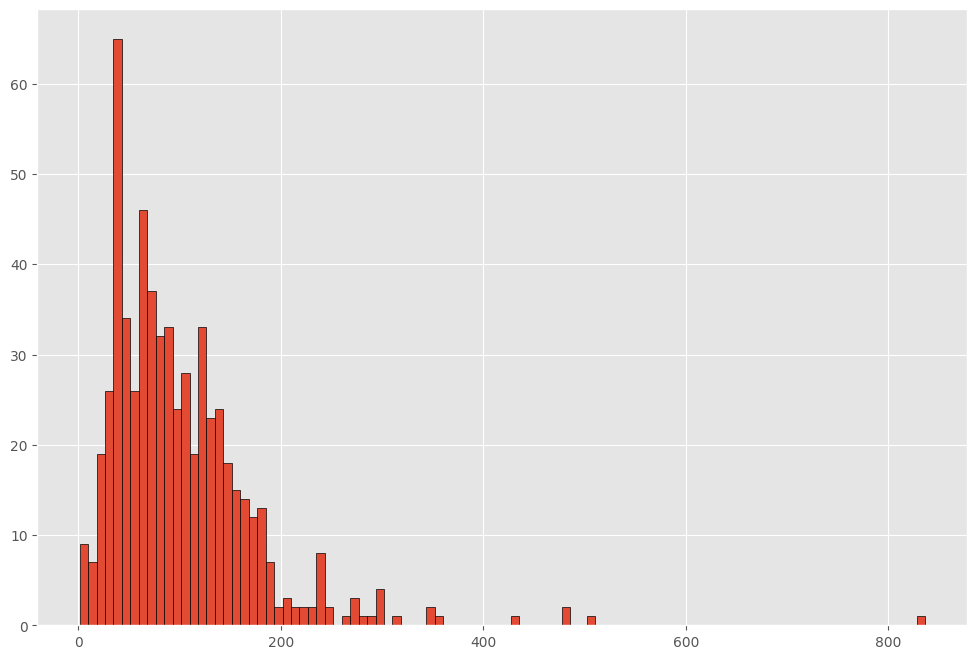

In [205]:
plt.figure(figsize=(12,8))
plt.hist(mean_times, bins=100, edgecolor='black')
plt.show()

In [206]:
time_bins=[0, 100, 250, 400, 1000]
labels=['Low', 'Medium', 'High', 'Critical']
mean_times['bin'] = pd.cut(mean_times['mean_times'], bins=time_bins, labels=labels)

In [207]:
mean_times.head()

,mean_times,bin
EQUIPMENT_ID,,
1.0,92.747840,Low
300017213.0,120.157895,Medium
300017214.0,130.941000,Medium
300017215.0,62.892857,Low
300017217.0,93.736364,Low


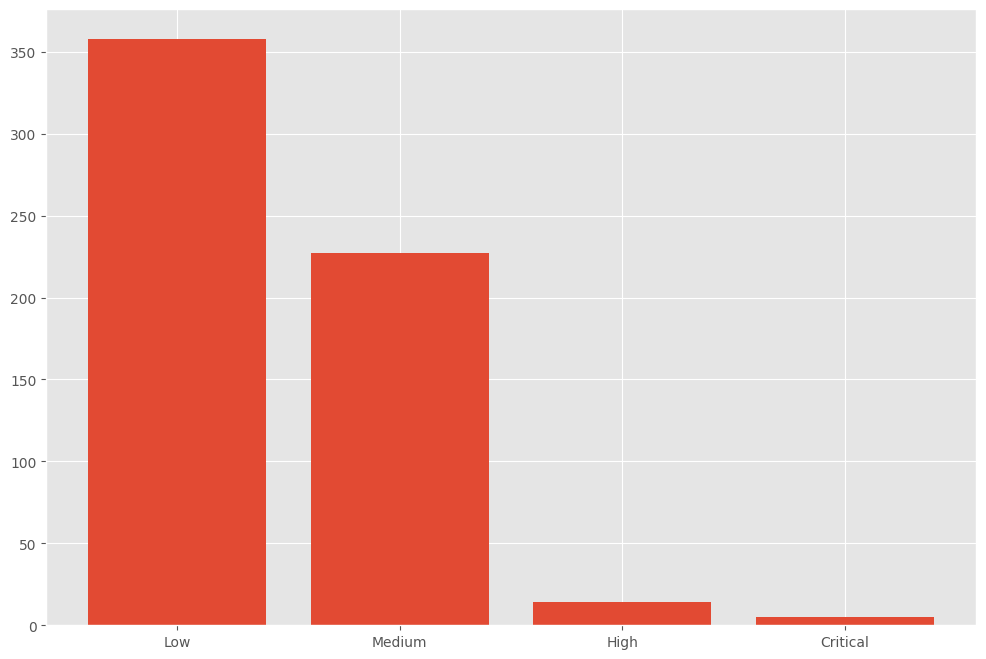

In [208]:
plt.figure(figsize=(12,8))
bin_counts = mean_times.groupby('bin').size()
plt.bar(bin_counts.index, bin_counts.values)
plt.show()

In [209]:
df_sil = pd.merge(df_sil, mean_times, on=('EQUIPMENT_ID'), how='left')

In [210]:
df_sil.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,mean_times,bin
0,901724580,G261,SILVERSTONE,2023-03-01,2023-03-01,12:52:00.000,12:52:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,92.74784,Low
1,207731527,G261,SILVERSTONE,2022-12-14,2022-12-14,13:04:00.000,17:30:00.000,100.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,92.74784,Low
2,200003228916,G261,SILVERSTONE,2022-08-05,2022-08-05,19:06:00.000,21:40:00.000,153.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,92.74784,Low
3,200000808319,G261,SILVERSTONE,2018-05-16,2018-05-16,18:11:00.000,19:01:00.000,50.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,92.74784,Low
4,401519840,G261,SILVERSTONE,2021-07-23,2021-07-23,13:01:00.000,16:50:00.000,422.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,92.74784,Low


In [211]:
df_sil_low = df_sil[(df_sil['bin']=='Low') & (df_sil['EXECUTION_START_DATE'] > '2016-10-01')].filter(['EXECUTION_START_DATE'])

In [212]:
df_sil_low

,EXECUTION_START_DATE
0,2023-03-01
1,2022-12-14
2,2022-08-05
3,2018-05-16
4,2021-07-23
...,...
630898,2022-01-24
630899,2020-10-23
630900,2022-04-10
630901,2022-08-18


In [213]:
count_orders_low = df_sil_low.groupby('EXECUTION_START_DATE').agg(
    counts = ('EXECUTION_START_DATE', 'size')
).sort_values(by='EXECUTION_START_DATE')

count_orders_low.head()

,counts
EXECUTION_START_DATE,
2016-10-02,48
2016-10-03,183
2016-10-04,221
2016-10-05,213
2016-10-06,222


## Prophet

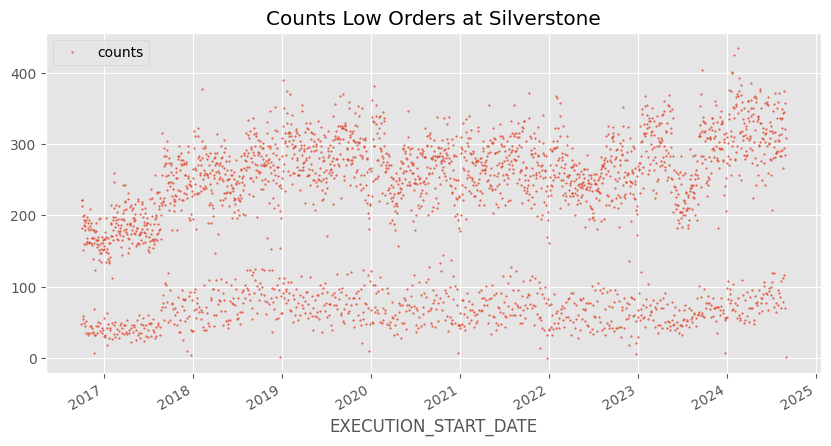

In [214]:
color_pal = sns.color_palette()
count_orders_low.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Counts Low Orders at Silverstone')
plt.show()

In [219]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(count_orders_low, label='counts')
features_and_target = pd.concat([X, y], axis=1)

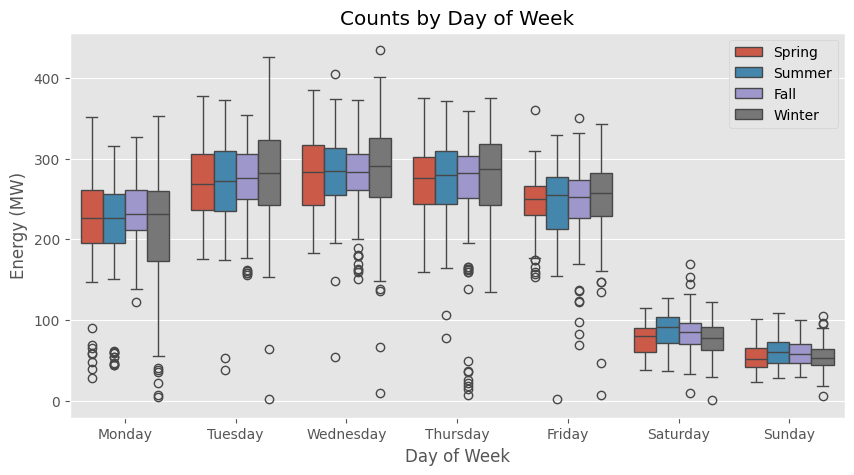

In [233]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='counts',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Counts by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [220]:
count_orders_low.index.max()

Timestamp('2024-08-30 00:00:00')

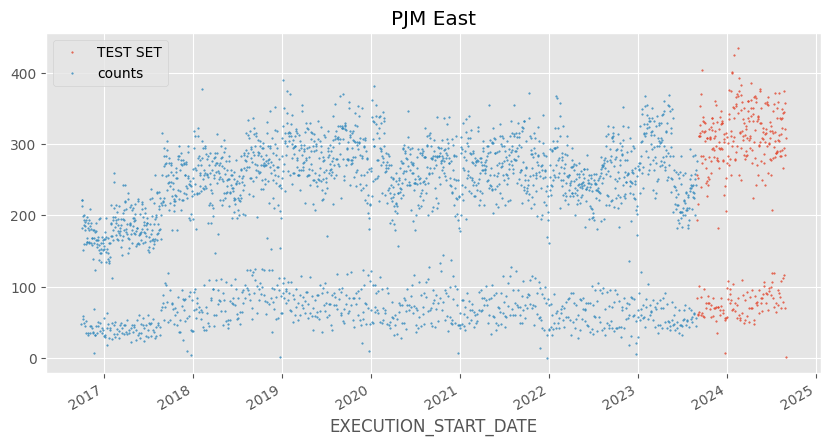

In [234]:
split_date = '2023-08-30'
count_orders_low_train = count_orders_low.loc[count_orders_low.index <= split_date].copy()
count_orders_low_test = count_orders_low.loc[count_orders_low.index > split_date].copy()

# Plot train and test so you can see where we have split
count_orders_low_test \
    .rename(columns={'counts': 'TEST SET'}) \
    .join(count_orders_low_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

In [236]:
counts_train_prophet = count_orders_low_train.reset_index() \
    .rename(columns={'EXECUTION_START_DATE':'ds',
                     'counts':'y'})



In [239]:
%%time
model = Prophet()
model.fit(counts_train_prophet)

00:40:14 - cmdstanpy - INFO - Chain [1] start processing
00:40:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 76.5 ms, sys: 12.8 ms, total: 89.3 ms
Wall time: 170 ms


In [241]:
# Predict on test set with model
count_orders_low_test_prophet = count_orders_low_test.reset_index() \
    .rename(columns={'EXECUTION_START_DATE':'ds',
                     'counts':'y'})

count_orders_low_test_fcst = model.predict(count_orders_low_test_prophet)

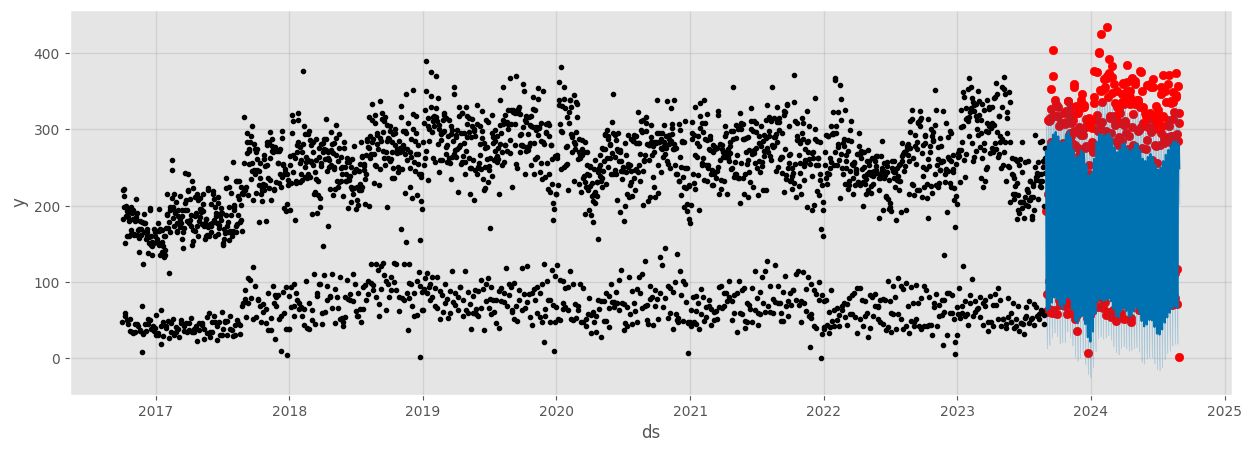

In [242]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(count_orders_low_test.index, count_orders_low_test['counts'], color='r')
fig = model.plot(count_orders_low_test_fcst, ax=ax)

In [252]:
mape_sil_low = mean_absolute_percentage_error(y_true=count_orders_low_test['counts'],
                               y_pred=count_orders_low_test_fcst['yhat'])

print(f'MAPE: {mape_sil_low:.4f}')

MAPE: 0.6376


## Function

### Create Dataframes Based on Location

In [260]:
df_roma = df[df['PRODUCTION_LOCATION']=='ROMA']
df_monza = df[df['PRODUCTION_LOCATION']=='MONZA']
df_cota = df[df['PRODUCTION_LOCATION']=='COTA']
df_monaco = df[df['PRODUCTION_LOCATION']=='MONACO']
df_suzuka = df[df['PRODUCTION_LOCATION']=='SUZUKA']
df_silverstone = df[df['PRODUCTION_LOCATION']=='SILVERSTONE']
